In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [ ]:
from google.colab import files
#upload Animal_photos.zip here or on the side
data_zip = files.upload()

Saving Animal_photos.zip to Animal_photos.zip


In [4]:
#extract zip in browser so photos are accessable
!unzip Animal_photos.zip

Archive:  Animal_photos.zip
   creating: Animal_photos/Cats/
  inflating: Animal_photos/Cats/cat_1_0.jpg  
  inflating: Animal_photos/Cats/cat_1_1.jpg  
  inflating: Animal_photos/Cats/cat_1_10.jpg  
  inflating: Animal_photos/Cats/cat_1_11.jpg  
  inflating: Animal_photos/Cats/cat_1_12.jpg  
  inflating: Animal_photos/Cats/cat_1_13.jpg  
  inflating: Animal_photos/Cats/cat_1_14.jpg  
  inflating: Animal_photos/Cats/cat_1_2.jpg  
  inflating: Animal_photos/Cats/cat_1_3.jpg  
  inflating: Animal_photos/Cats/cat_1_4.jpg  
  inflating: Animal_photos/Cats/cat_1_5.jpg  
  inflating: Animal_photos/Cats/cat_1_6.jpg  
  inflating: Animal_photos/Cats/cat_1_7.jpg  
  inflating: Animal_photos/Cats/cat_1_8.jpg  
  inflating: Animal_photos/Cats/cat_1_9.jpg  
  inflating: Animal_photos/Cats/cat_10_0.jpg  
  inflating: Animal_photos/Cats/cat_10_1.jpg  
  inflating: Animal_photos/Cats/cat_10_10.jpg  
  inflating: Animal_photos/Cats/cat_10_11.jpg  
  inflating: Animal_photos/Cats/cat_10_12.jpg  
  infl

In [5]:
import pathlib
#locate data set phots
data_dir = pathlib.Path("/content/Animal_photos")
#check if done correct, should print out True
data_dir.exists()

True

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
#Lists total amount of photos, cats and dogs
#should be 1873

1873


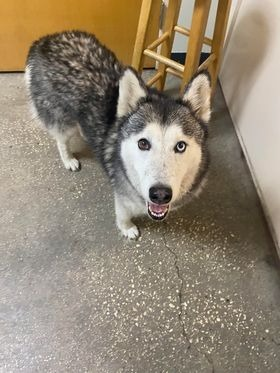

In [7]:
dogs = list(data_dir.glob('Dogs/*'))
PIL.Image.open(str(dogs[1]))

/content/Animal_photos/Cats/cat_65_2.jpg


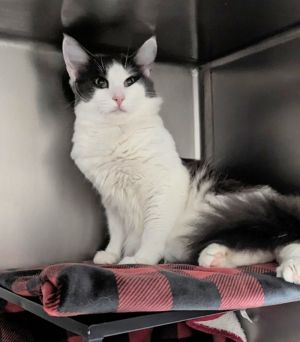

In [12]:
cats = list(data_dir.glob("Cats/*"))
print(cats[0])
PIL.Image.open(cats[0])

In [8]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1873 files belonging to 2 classes.
Using 1499 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1873 files belonging to 2 classes.
Using 374 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Cats', 'Dogs']


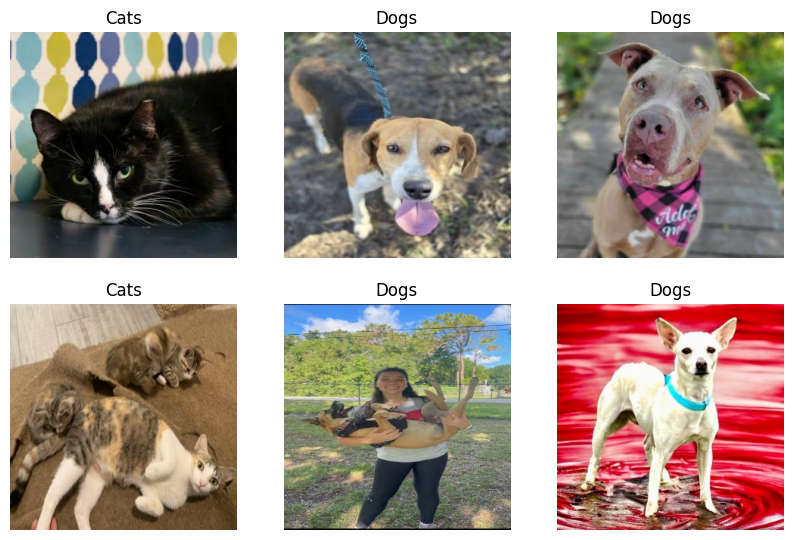

In [32]:
import matplotlib.pyplot as plt
#first 6 images of the data set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

  #image batch forms a tensor of shape (32, 300, 300, 3) batch of 32 images, 300x300p, 3 color channels
  #labels_batch has the labels for the 32 images

(32, 300, 300, 3)
(32,)


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
normalization_layer = layers.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [38]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1

In [41]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
47/47 [==============================] - 172s 4s/step - loss: 0.7884 - accuracy: 0.6558 - val_loss: 0.5066 - val_accuracy: 0.7594
Epoch 2/10
47/47 [==============================] - 166s 4s/step - loss: 0.4543 - accuracy: 0.7765 - val_loss: 0.4423 - val_accuracy: 0.8102
Epoch 3/10
47/47 [==============================] - 157s 3s/step - loss: 0.3871 - accuracy: 0.8245 - val_loss: 0.4299 - val_accuracy: 0.8128
Epoch 4/10
47/47 [==============================] - 152s 3s/step - loss: 0.2768 - accuracy: 0.8833 - val_loss: 0.4241 - val_accuracy: 0.8235
Epoch 5/10
47/47 [==============================] - 152s 3s/step - loss: 0.1586 - accuracy: 0.9440 - val_loss: 0.4553 - val_accuracy: 0.8342
Epoch 6/10
47/47 [==============================] - 153s 3s/step - loss: 0.0892 - accuracy: 0.9753 - val_loss: 0.4965 - val_accuracy: 0.8209
Epoch 7/10
47/47 [==============================] - 152s 3s/step - loss: 0.0426 - accuracy: 0.9860 - val_loss: 0.7497 - val_accuracy: 0.8155
Epoch 8/10
47

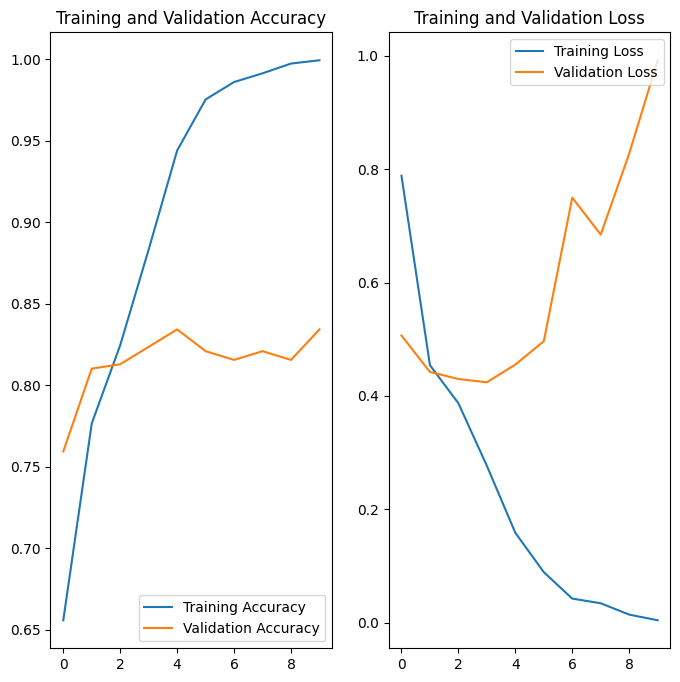

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

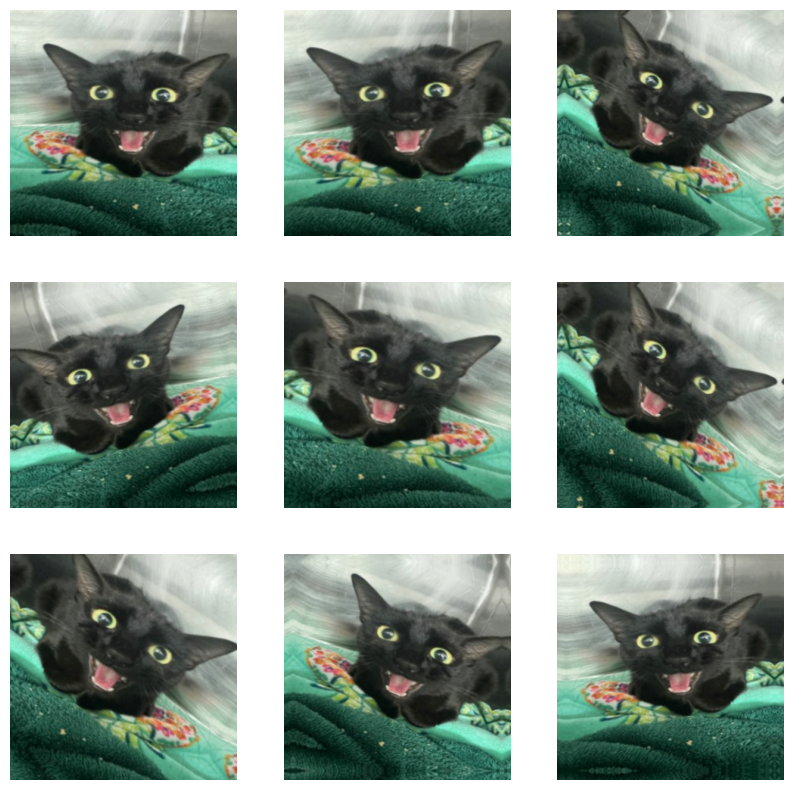

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [45]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [46]:
#compiling model to fite overfitting using data augmentation and dropout
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                 

In [48]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
47/47 [==============================] - 199s 4s/step - loss: 1.3330 - accuracy: 0.5690 - val_loss: 0.6566 - val_accuracy: 0.6631
Epoch 2/15
47/47 [==============================] - 192s 4s/step - loss: 0.6023 - accuracy: 0.6778 - val_loss: 0.5416 - val_accuracy: 0.7273
Epoch 3/15
47/47 [==============================] - 179s 4s/step - loss: 0.5357 - accuracy: 0.7418 - val_loss: 0.4864 - val_accuracy: 0.7674
Epoch 4/15
47/47 [==============================] - 177s 4s/step - loss: 0.5097 - accuracy: 0.7572 - val_loss: 0.4418 - val_accuracy: 0.8128
Epoch 5/15
47/47 [==============================] - 194s 4s/step - loss: 0.4961 - accuracy: 0.7692 - val_loss: 0.4612 - val_accuracy: 0.7647
Epoch 6/15
47/47 [==============================] - 206s 4s/step - loss: 0.4753 - accuracy: 0.7839 - val_loss: 0.4006 - val_accuracy: 0.8182
Epoch 7/15
47/47 [==============================] - 211s 4s/step - loss: 0.4245 - accuracy: 0.8079 - val_loss: 0.4245 - val_accuracy: 0.8021
Epoch 8/15
47

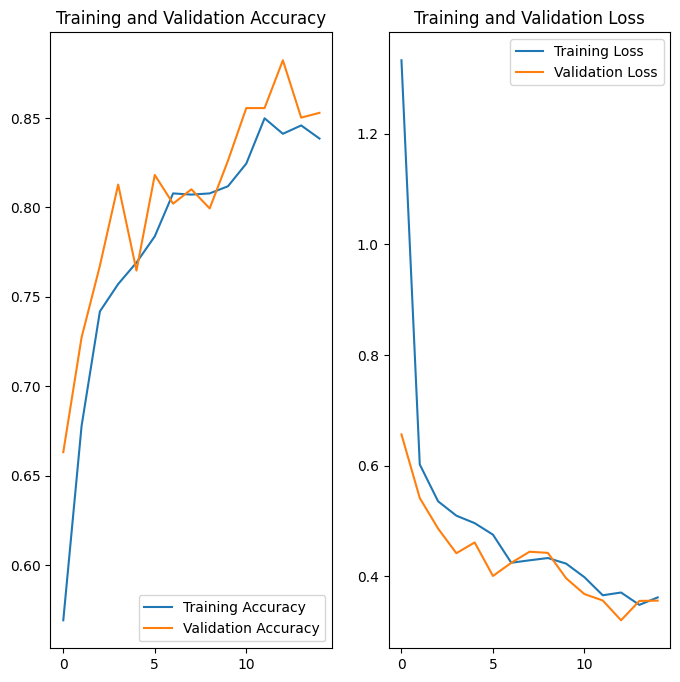

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
#export model after augemtation and dropout
model.save("/content/model/")

In [53]:
#convert folder into zip so it can be downlaoded
!zip -r /content/ExportedModel.zip /content/model/

  adding: content/model/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 89%)
  adding: content/model/keras_metadata.pb (deflated 92%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/model/variables/variables.index (deflated 64%)
  adding: content/model/assets/ (stored 0%)
